In [494]:
import numpy as np
from pymoo.indicators.hv import HV
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import qmc  # For Latin Hypercube Sampling
import torch
import gpytorch
import random
from PIL import Image
from datetime import datetime
#import scienceplots
from scipy.stats import norm
import functionBank as func
from sklearn.preprocessing import MinMaxScaler
import scienceplots
plt.style.available
plt.style.use(['science', 'notebook'])

Initial Population:
[[0.12950088 0.50373131]
 [0.13489758 0.52729095]
 [0.5774186  0.1289065 ]
 [0.19527667 0.40591475]
 [0.37362414 0.21233104]
 [0.33104669 0.52604382]
 [0.13753238 0.61823665]
 [0.18757353 0.62574802]
 [0.13328908 0.55451455]
 [1.         0.00670168]
 [0.07972718 0.62429579]
 [0.72013848 0.31349381]
 [0.83472731 0.2581518 ]
 [0.83278363 0.02413408]
 [0.         1.        ]
 [0.0692002  0.64160418]
 [0.67964655 0.08560305]
 [0.2017936  0.38241951]
 [0.09260111 0.61032229]
 [0.29568966 0.30289438]
 [0.2752755  0.30504135]
 [0.98674896 0.00304999]
 [0.33873313 0.54306463]
 [0.21319234 0.43822807]
 [0.25491365 0.33086279]
 [0.48322187 0.41976184]
 [0.44245045 0.27097159]
 [0.37083823 0.28604076]
 [0.27010262 0.48037584]
 [0.64498449 0.38101864]
 [0.62502059 0.07815516]
 [0.49049869 0.30968068]
 [0.0176838  0.84659241]
 [0.34109735 0.24257207]
 [0.14368164 0.47111021]
 [0.57357913 0.44522388]
 [0.5538183  0.26911478]
 [0.17022716 0.48985628]
 [0.16909459 0.5293356 ]
 [0.6

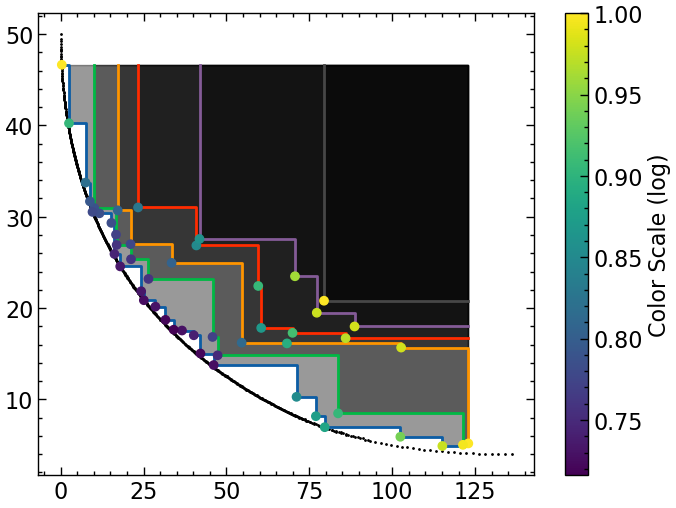

[0.74418162 0.7588773  0.85164007 0.73283522 0.72637116 0.85120724
 0.80627338 0.82881304 0.77204714 1.         0.78763045 0.9811024
 0.97969347 0.94032306 1.         0.79364132 0.9053626  0.72629395
 0.78474851 0.72876928 0.71609442 0.99499152 0.86006292 0.75743129
 0.72118299 0.90613916 0.81327853 0.77055212 0.80520233 1.
 0.87407515 0.86802939 0.90376731 0.72067671 0.73486604 0.96038601
 0.89364037 0.75780553 0.77601557 0.97034401 0.74057    0.97723933
 0.91567223 0.97564991 0.78015967 0.78306477 0.74972416 0.73135312
 0.88280919 0.81870686]


In [495]:

import optimiserBank as opt
import functionBank as func
from matplotlib.colors import LogNorm

bounds = np.array([(0,5), (0,3)])
lowBounds = bounds[:,0]
highBounds = bounds[:,1]
sampler = qmc.LatinHypercube(d=len(bounds))
sample = sampler.random(n=50)
initPopulation = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
print('Initial Population:')
# print(initPopulation)
# plt.scatter(initPopulation[:,0], initPopulation[:,1])
# plt.show()

trueParetoFront = np.loadtxt('paretoFronts/binhAndKornPareto.txt')


objvTargets = np.empty((0,2))

for i in range(0, 50):

    newObjvTgt = opt.MOobjective_function(initPopulation[i], func.binhAndKorn, 2)
    # print(newObjvTgt)
    while np.any(np.isnan(newObjvTgt)):
        newSample = np.random.uniform(lowBounds, high=highBounds, size=(2,))
        newObjvTgt = opt.MOobjective_function(newSample, func.binhAndKorn, 2)

    objvTargets = np.vstack((objvTargets, newObjvTgt))

# print(objvTargets)
scaler = MinMaxScaler(feature_range=(0, 1))

objsNormalised = scaler.fit_transform(objvTargets)
print(objsNormalised)


scalarisedValues, pareto_shells = func.HypI(objsNormalised)

# pareto_shells = scaler.inverse_transform(pareto_shells)

# print(len(pareto_shells))
# print(pareto_shells[1].shape)
# print('paretoshells = ', pareto_shells)
# print(np.sort(pareto_shells[1], axis=0))

# reference_point = [140,50]
reference_point = np.max(objvTargets, axis=0)

sc = plt.scatter(objvTargets[:,0], objvTargets[:,1], c = scalarisedValues, alpha = 1, zorder=10)
for i in range(0,len(pareto_shells)):

    sortedShell = pareto_shells[i][pareto_shells[i][:,0].argsort()]
    sortedShell = scaler.inverse_transform(sortedShell)

    x_steps = []
    y_steps = []

    # Start from the first Pareto point
    x_steps.append(reference_point[0])
    y_steps.append(reference_point[1])

    for i in range(len(sortedShell)):
        # Move horizontally first
        x_steps.append(sortedShell[i, 0])
        y_steps.append(y_steps[-1])  # Keep y the same
        
        # Then move vertically
        x_steps.append(sortedShell[i, 0])
        y_steps.append(sortedShell[i, 1])

    # Close the polygon by connecting back to the reference point
    x_steps.append(reference_point[0])
    y_steps.append(sortedShell[-1, 1])

    plt.fill(x_steps, y_steps, alpha=0.4, c='k', zorder=0)
    
    # print(f'sorted shell {i} = ', sortedShell)

    # plt.plot(x_steps, y_steps, c='k')
    plt.plot(np.delete(x_steps, 0), np.delete(y_steps,0))
plt.scatter(trueParetoFront[:,0], trueParetoFront[:,1], c='black', s=1)
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale (log)')
# plt.scatter(140,50)
plt.show()

print(scalarisedValues)